# 手稿图表
> zhenkun.shi@tib.cas.cn  
> 2025-01-23


## 1. 引入必要的包

In [7]:
import sys,os
sys.path.insert(0, os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(1,'../')
from config import conf as cfg
import pandas as pd
import numpy as np
import matplotlib
import plotly.graph_objects as go
from itertools import chain, combinations
from modules import commonfunction as cmfunc
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators, plot
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. 加载数据

In [2]:
pdata = pd.read_feather('/hpcfs/fhome/shizhenkun/codebase/RXNRECer/case/2018later/res/res_case2018Later_250206.feather').rename(columns={'pred_alpf_correct':'pred_rxnrecer_correct'})
pdata.head(3)

,uniprot_id,rxn_groundtruth,ec_groundtruth,ec_ecblast,reaction_ecblast,ec_deepec,reaction_deepec,ec_clean,reaction_clean,ec_ecrecer,...,rxn_cos_t5,rxn_alpf,pred_cos_unirep_correct,pred_eu_t5_correct,pred_cos_esm_correct,pred_eu_esm_correct,pred_blast_correct,pred_rxnrecer_correct,pred_eu_unirep_correct,pred_cos_t5_correct
0,A9JLI2,-,-,-,-,NO-PREDICTION,NO-PREDICTION,3.2.2.6;1.4.3.2;4.2.3.81,RHEA:31427;RHEA:16301;RHEA:13781,-,...,-,-,True,True,True,True,True,True,True,True
1,A9JLI3,-,-,-,-,NO-PREDICTION,NO-PREDICTION,4.6.1.18,EC-WITHOUT-REACTION,-,...,-,-,True,True,True,True,True,True,True,True
2,A9JLI5,-,-,-,-,NO-PREDICTION,NO-PREDICTION,1.4.3.2,RHEA:13781,-,...,-,-,True,True,True,True,True,True,True,True


In [3]:
pdata = pdata[pdata.rxn_groundtruth!='-'].reset_index(drop=True)
print(f'Enzymes:{len(pdata)}')

Enzymes:3205


## 3. 准备图表数据

In [4]:
# EC方法
methods_ec ={'ecrecer','catfam' }
# Direct方法
methods_direct ={'blast',  'cos_esm','cos_unirep', 'cos_t5','rxnrecer' }

fig_cols = list(f'pred_ec_{item}_correct' for item in methods_ec) + list(f'pred_{item}_correct' for item in methods_direct)
fig_cols

['pred_ec_ecrecer_correct',
 'pred_ec_catfam_correct',
 'pred_cos_esm_correct',
 'pred_cos_unirep_correct',
 'pred_rxnrecer_correct',
 'pred_blast_correct',
 'pred_cos_t5_correct']

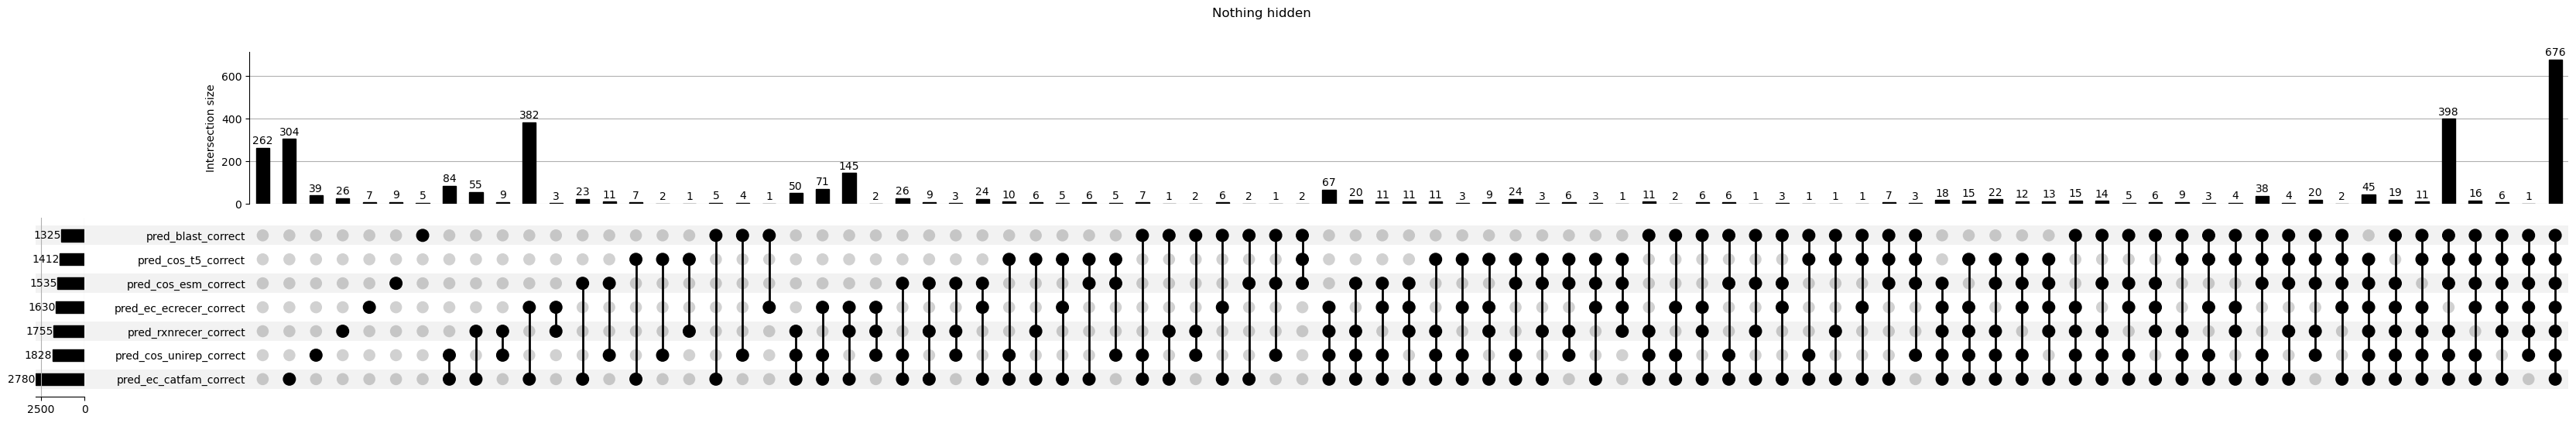

In [5]:
fig_data = ~pdata[fig_cols]
upset_data = from_indicators(fig_data.columns, fig_data)
plt.rcParams["figure.figsize"] = (12, 100)  # 默认宽 12 高 8
plot(upset_data, show_counts=True)
plt.suptitle('Nothing hidden')
plt.show()


In [6]:
# EC方法
methods_ec ={'ecblast', 'deepec', 'clean', 'ecrecer', 'ecpred', 'catfam', 'priam' }
# Direct方法
methods_direct ={'blast',  'cos_esm','cos_unirep', 'cos_t5','rxnrecer' }

fig_cols = list(f'pred_ec_{item}_correct' for item in methods_ec) + list(f'pred_{item}_correct' for item in methods_direct)

methods = ['ECRECer','CatFam', 'T5', 'ESM', 'UniRep', 'MSAviaRXN', 'RXNRECer']

statistic_data = pdata[fig_cols].rename(columns={'pred_ec_ecrecer_correct':'ECRECer',
                                'pred_ec_priam_correct':'PRIAM',
                                'pred_ec_catfam_correct':'CatFam',
                                'pred_ec_clean_correct':'Clean',
                                'pred_ec_deepec_correct':'DeepEC',
                                'pred_ec_ecblast_correct':'MSAviaEC',
                                'pred_ec_ecpred_correct':'ECpred',
                                'pred_cos_t5_correct':'T5',
                                'pred_cos_esm_correct':'ESM',
                                'pred_cos_unirep_correct':'UniRep',
                                'pred_blast_correct':'MSAviaRXN',
                                'pred_rxnrecer_correct':'RXNRECer',
                                }
                       )
pd.options.display.max_rows = 20
statistic_data

,ECRECer,DeepEC,MSAviaEC,Clean,PRIAM,CatFam,ECpred,ESM,UniRep,RXNRECer,MSAviaRXN,T5
0,True,True,True,True,False,False,False,False,True,True,True,True
1,True,True,True,True,False,False,False,True,True,True,True,True
2,True,True,True,True,False,False,False,True,True,True,True,True
3,True,False,True,True,False,False,False,True,True,True,True,True
4,True,True,True,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3200,False,False,False,False,False,False,False,False,False,False,False,False
3201,False,False,False,False,False,False,False,False,False,False,False,False
3202,False,False,False,False,False,False,False,False,False,False,False,False
3203,False,False,False,False,False,False,False,False,False,False,False,False


In [26]:
def caculate_interation_set(statistic_data, methods, standard=False):
    # 生成所有非空子集
    all_combinations = list(chain.from_iterable(combinations(methods, r) for r in range(1, len(methods) + 1)))
    
    statistic_data = statistic_data.copy()
    res = []

    for col in all_combinations:
        # 使用 NumPy 向量化运算过滤数据
        mask = np.logical_and.reduce([statistic_data[c] == standard for c in col])
        num = np.sum(mask)  # 计算符合条件的行数
        res.append([col, round((3205-num)/3205,4)])
    res =pd.DataFrame(res, columns=['methodCombinations', 'Accuracy'])
    return res



In [27]:
methods = ['ECRECer','CatFam', 'DeepEC', 'MSAviaEC']
res = caculate_interation_set(statistic_data=statistic_data, methods=methods, standard=False)
pd.options.display.max_rows = None
res.sort_values(by='Accuracy', ascending=False)


,methodCombinations,Accuracy
14,"(ECRECer, CatFam, DeepEC, MSAviaEC)",0.5133
12,"(ECRECer, DeepEC, MSAviaEC)",0.5120
11,"(ECRECer, CatFam, MSAviaEC)",0.5114
6,"(ECRECer, MSAviaEC)",0.5101
10,"(ECRECer, CatFam, DeepEC)",0.5014
5,"(ECRECer, DeepEC)",0.4977
4,"(ECRECer, CatFam)",0.4961
0,"(ECRECer,)",0.4914
13,"(CatFam, DeepEC, MSAviaEC)",0.3051
8,"(CatFam, MSAviaEC)",0.2989


In [28]:
res

,methodCombinations,Accuracy
0,"(ECRECer,)",0.4914
1,"(CatFam,)",0.1326
2,"(DeepEC,)",0.1470
3,"(MSAviaEC,)",0.2892
4,"(ECRECer, CatFam)",0.4961
5,"(ECRECer, DeepEC)",0.4977
6,"(ECRECer, MSAviaEC)",0.5101
7,"(CatFam, DeepEC)",0.2016
8,"(CatFam, MSAviaEC)",0.2989
9,"(DeepEC, MSAviaEC)",0.2967


In [29]:
methods = ['ECRECer','CatFam', 'T5', 'ESM', 'UniRep', 'MSAviaRXN', 'RXNRECer']
res = caculate_interation_set(statistic_data=statistic_data, methods=methods, standard=False)
pd.options.display.max_rows = None
# res.sort_values(by='Accuracy', ascending=False)
res

,methodCombinations,Accuracy
0,"(ECRECer,)",0.4914
1,"(CatFam,)",0.1326
2,"(T5,)",0.5594
3,"(ESM,)",0.5211
4,"(UniRep,)",0.4296
5,"(MSAviaRXN,)",0.5866
6,"(RXNRECer,)",0.4524
7,"(ECRECer, CatFam)",0.4961
8,"(ECRECer, T5)",0.7423
9,"(ECRECer, ESM)",0.7279


In [30]:
res.sort_values(by='Accuracy', ascending=False)

,methodCombinations,Accuracy
126,"(ECRECer, CatFam, T5, ESM, UniRep, MSAviaRXN, ...",0.7891
124,"(ECRECer, T5, ESM, UniRep, MSAviaRXN, RXNRECer)",0.7888
121,"(ECRECer, CatFam, T5, ESM, MSAviaRXN, RXNRECer)",0.7872
110,"(ECRECer, T5, ESM, MSAviaRXN, RXNRECer)",0.7869
122,"(ECRECer, CatFam, T5, UniRep, MSAviaRXN, RXNRE...",0.7856
111,"(ECRECer, T5, UniRep, MSAviaRXN, RXNRECer)",0.7853
119,"(ECRECer, CatFam, T5, ESM, UniRep, MSAviaRXN)",0.7841
108,"(ECRECer, T5, ESM, UniRep, MSAviaRXN)",0.7838
123,"(ECRECer, CatFam, ESM, UniRep, MSAviaRXN, RXNR...",0.7832
112,"(ECRECer, ESM, UniRep, MSAviaRXN, RXNRECer)",0.7828


In [233]:
res.to_excel('methodCombinations.xlsx', index=False)

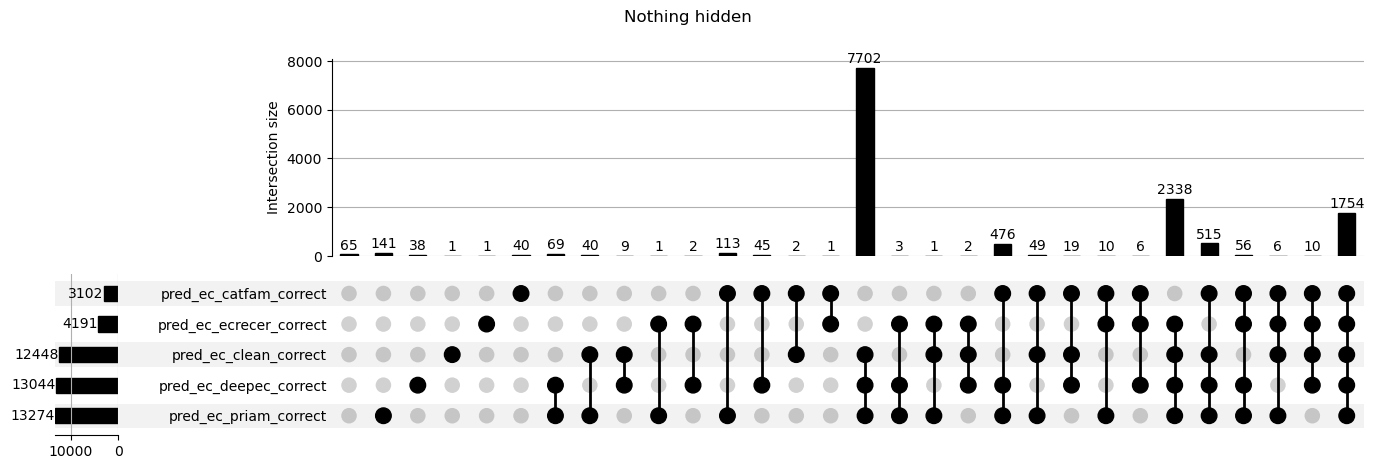

In [267]:
fig_data = ~pdata[fig_cols]
upset_data = from_indicators(fig_data.columns[:5], fig_data)
plt.rcParams["figure.figsize"] = (12, 100)  # 默认宽 12 高 8
plot(upset_data, show_counts=True)
plt.suptitle('Nothing hidden')
plt.show()